In [1]:
import collections
import itertools
import json
import pathlib

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import hier_torch
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
device = torch.device('cuda')

In [3]:
import configs.imagenet

base_config = configs.imagenet.get_config()
base_config.dataset_root = '/home/jack/data/torchvision/imagenet/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

In [4]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8)

In [5]:
is_leaf = tree.leaf_mask()
specificity = -tree.num_leaf_descendants()
not_trivial = (tree.num_children() != 1)
subtract_children_fn = hier_torch.SubtractChildren(tree)

In [6]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    'exclusive': lambda p: np.argmax(subtract_children_fn(torch.from_numpy(p)).numpy(), axis=-1),
}

In [7]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
}

metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

In [8]:
Experiment = collections.namedtuple('Experiment', ['config_file', 'model_file', 'title'])

def standard_experiment(experiment_dir, epoch, title=None):
    return Experiment(
        config_file=pathlib.Path(experiment_dir) / 'config.json',
        model_file=pathlib.Path(experiment_dir) / f'checkpoints/epoch-{epoch:04d}.pth',
        title=title,
    )

In [29]:
# experiments = {
#     'flat-lr{lr}-wd{wd}-ep{ep}': standard_experiment(
#         experiment_dir=f'/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-25-imagenet-features/vitb32-linear-flat_softmax-lr{lr}-wd{wd}-ep{ep}/',
#         epoch=int(ep))
#     for lr, wd, ep in itertools.product(['0.1', '0.01', '0.001'], ['0.0001', '0.00001'], ['20', '100'])
# }

PLOT_DIR = 'output/plots/imagenet-res50-ep15'
experiments = {
    'flat_softmax': standard_experiment(
        title='Flat',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-05-imagenet-acc/flat-lr-0.01-wd-0.0003-ep-15',
        epoch=15),
    'hier_softmax': standard_experiment(
        title='Cond softmax',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-05-imagenet-acc/hier-lr-0.01-wd-0.0003-ep-15-b-64',
        epoch=15),
    'share_random_cut-0': standard_experiment(
        title='Deep-RTC',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-05-imagenet-acc/share_random_cut-0-lr-0.01-wd-0.0003-ep-15-b-64',
        epoch=15),
    'soft-margin-incorrect-5': standard_experiment(
        title='Soft-max-margin',
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-05-imagenet-acc/soft_margin-incorrect-5-lr-0.01-wd-0.0003-ep-15-b-64',
        epoch=15),
}

method_titles = {k: v.title for k, v in experiments.items()}

In [10]:
{name: pathlib.Path(experiment.config_file).exists() for name, experiment in experiments.items()}

{'flat_softmax': True,
 'hier_softmax': True,
 'share_random_cut-0': True,
 'soft-margin-incorrect-5': True}

In [11]:
markers = {
    'leaf': 'o',
    'majority': '^',
    # 'exclusive': 'd',
}

colors = dict(zip(
    experiments,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [12]:
def apply_model(net, pred_fn, min_threshold):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), None):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [13]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
#     specificity_seq = [np.flip(seq) for seq in specificity_seq]
#     metric_values_seq = {field: np.flip(seq) for field, seq in metric_values_seq.items()}
#     pareto_scores, pareto_totals = metrics.operating_curve(specificity_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [14]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [16]:
# MIN_THRESHOLD = 0.1  # Values less than 0.5 may increase runtime significantly.
MIN_THRESHOLD = None

def _update_config(config):
    # Perform necessary changes to adapt old configs.
    # ** Modifies config in-place! **
    setattr(config, 'train_with_leaf_targets', getattr(config, 'train_with_leaf_targets', True))
    return config

for name, (config_file, model_file, _) in experiments.items():
    if name in results:
        print('cached:', name)
        continue
    # Load model.
    with open(config_file, 'r') as f:
        config = _update_config(ml_collections.ConfigDict(json.load(f)))
    config = _update_config(config)
    num_outputs = main.get_num_outputs(config.predict, tree)
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, tree, device)
    outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD)
    pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
    results[name] = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

apply:   6% (11/196); T=0.473 f=2.11; mean T=0.473 f=2.11; elapsed 0:00:05; remaining 0:01:28 of 0:01:33
apply:  15% (29/196); T=0.289 f=3.46; mean T=0.359 f=2.79; elapsed 0:00:10; remaining 0:01:00 of 0:01:10
apply:  23% (46/196); T=0.295 f=3.39; mean T=0.335 f=2.98; elapsed 0:00:15; remaining 0:00:50 of 0:01:06
apply:  33% (64/196); T=0.282 f=3.55; mean T=0.320 f=3.12; elapsed 0:00:20; remaining 0:00:42 of 0:01:03
apply:  41% (81/196); T=0.303 f=3.30; mean T=0.317 f=3.16; elapsed 0:00:26; remaining 0:00:36 of 0:01:02
apply:  51% (99/196); T=0.278 f=3.59; mean T=0.310 f=3.23; elapsed 0:00:31; remaining 0:00:30 of 0:01:01
apply:  60% (117/196); T=0.289 f=3.46; mean T=0.306 f=3.26; elapsed 0:00:36; remaining 0:00:24 of 0:01:00
apply:  69% (135/196); T=0.285 f=3.51; mean T=0.304 f=3.29; elapsed 0:00:41; remaining 0:00:19 of 0:00:59
apply:  78% (152/196); T=0.301 f=3.32; mean T=0.303 f=3.30; elapsed 0:00:46; remaining 0:00:13 of 0:00:59
apply:  87% (170/196); T=0.289 f=3.46; mean T=0.302 

In [54]:
# INTEGRALS = {
#     'AC(depth)': ('depth_recall', 'correct'),
#     'AC(info)': ('info_recall', 'correct'),
#     'AP(depth)': ('depth_recall', 'depth_precision'),
#     'AP(info)': ('info_recall', 'info_precision'),
#     'AC(exact)': ('exact', 'correct'),
# }

# auc = {
#     key: {
#         name: metrics.pareto_integrate(
#             results[name]['pareto_metrics'][x],
#             results[name]['pareto_metrics'][y])
#         for name in experiments if name in results
#     } for key, (x, y) in INTEGRALS.items()
# }

# table = pd.DataFrame(auc).style.format(lambda x: f'{100 * x:.1f}')
# print(table.to_latex())
# table

INTEGRALS = {
    'AC(depth)': ('depth_recall', 'correct'),
    'AC(info)': ('info_recall', 'correct'),
    'AP(depth)': ('depth_recall', 'depth_precision'),
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(exact)': ('exact', 'correct'),
}

auc = {
    integral_key: {
        name: metrics.pareto_integrate(
            results[name]['pareto_metrics'][x],
            results[name]['pareto_metrics'][y])
        for name in experiments if name in results
    } for integral_key, (x, y) in INTEGRALS.items()
}

auc = pd.DataFrame(auc)
auc = auc.set_index(auc.index.map(method_titles))
auc.style.format(lambda x: f'{x * 100:.1f}')

,AC(depth),AC(info),AP(depth),AP(info),AC(exact)
Flat,79.3,69.4,80.7,70.2,64.2
Cond softmax,76.5,65.4,78.4,66.4,59.1
Deep-RTC,74.5,67.1,78.0,68.3,62.8
Soft-max-margin,79.5,70.6,80.9,71.2,66.1


In [55]:
print(auc.style.format(lambda x: f'{x * 100:.1f}').to_latex())

\begin{tabular}{lrrrrr}
 & AC(depth) & AC(info) & AP(depth) & AP(info) & AC(exact) \\
Flat & 79.3 & 69.4 & 80.7 & 70.2 & 64.2 \\
Cond softmax & 76.5 & 65.4 & 78.4 & 66.4 & 59.1 \\
Deep-RTC & 74.5 & 67.1 & 78.0 & 68.3 & 62.8 \\
Soft-max-margin & 79.5 & 70.6 & 80.9 & 71.2 & 66.1 \\
\end{tabular}



In [45]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = [95, 90]

recalls = {
    (c, y): {
        name: metrics.pareto_intercept(
            results[name]['pareto_metrics']['correct'],
            results[name]['pareto_metrics'][y],
            c / 100)
        for name in results
    } for c in CORRECT for y in INTERCEPTS
}

recalls = pd.DataFrame(recalls)
recalls = recalls.set_index(recalls.index.map(method_titles))
recalls.style.format(lambda x: f'{x * 100:.1f}')

In [48]:
print(recalls.style.format(lambda x: f'{x * 100:.1f}').to_latex())

\begin{tabular}{lrrrrrr}
 & \multicolumn{3}{r}{95} & \multicolumn{3}{r}{90} \\
 & depth_recall & info_recall & exact & depth_recall & info_recall & exact \\
Flat & 64.2 & 48.4 & 41.2 & 70.9 & 56.9 & 49.9 \\
Cond softmax & 59.8 & 42.8 & 34.0 & 66.7 & 51.0 & 42.5 \\
Deep-RTC & 37.6 & 36.2 & 34.9 & 53.6 & 50.7 & 48.5 \\
Soft-max-margin & 64.5 & 53.3 & 49.0 & 72.5 & 61.3 & 56.8 \\
\end{tabular}



In [19]:
def plot_metrics(x, y, tickres=None, is_pr=True, save=False):
    plt.figure(figsize=(5, 4))
    for name in experiments:
        if name not in results:
            continue
        pred_metrics = results[name]['pred_metrics']
        pareto_scores = results[name]['pareto_scores']
        pareto_metrics = results[name]['pareto_metrics']
        ge = np.concatenate(([True], pareto_scores >= 0.5))
        le = np.concatenate(([False], pareto_scores <= 0.5))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[name], label=experiments[name].title or name)
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[name], linestyle='--')
        for method in ['leaf', 'majority']:  # pred_metrics.items():
            plt.plot(pred_metrics[method][x], pred_metrics[method][y],
                     color=colors[name], marker=markers[method],
                     markerfacecolor='none')

    ax = plt.gca()
    if is_pr:
        plt.xlim(left=0)
        plt.ylim(top=1)
        # plt.ylim(np.clip(plt.ylim(), 0, 1))
        # plt.xlim(np.clip(plt.xlim(), 0, 1))
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    # plt.axis('equal')
    # plt.gca().set_aspect(1)
    plt.grid()
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))
    plt.legend()

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}.pdf')

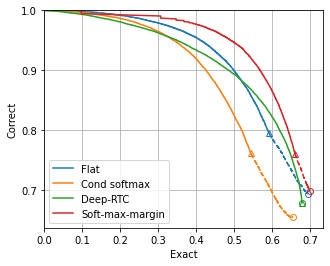

In [20]:
plot_metrics('exact', 'correct', tickres=0.1, save=True)

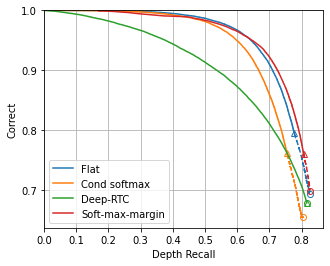

In [21]:
plot_metrics('depth_recall', 'correct', tickres=0.1, save=True)

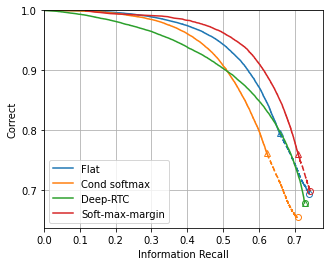

In [22]:
plot_metrics('info_recall', 'correct', tickres=0.1, save=True)

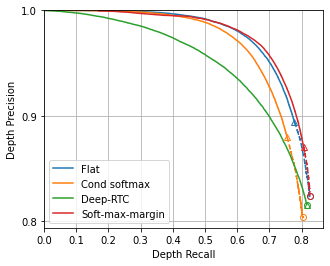

In [23]:
plot_metrics('depth_recall', 'depth_precision', tickres=0.1, save=True)

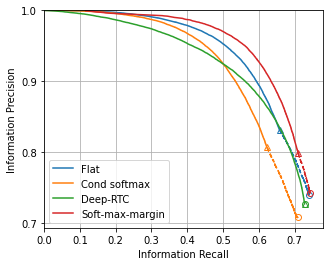

In [24]:
plot_metrics('info_recall', 'info_precision', tickres=0.1, save=True)